# RadBIN Cambio de enfoque
Tras re leer el trabajo de Melanie Berg más recientes, como una presentación del 2023, 
propone tras seleccionar un Liner Energy Transfer especifico (LET), en nuestro caso consideraremos una fluencia acumulada para binnings (teniendo distintos bins a lo largo del tiempo para un mismo dispositivo y dentro de cada bin, varios errores)
Se puede tener en cuenta de cada bin, la fluencia hasta un error FTF $\Phi_i$ por experimento-i, osea distintos intervalos de reset dentro de un bin j, la cual será una variable aleatoria tipo Poisson.
Es posible obtener el ratio $\sigma_{SEF_i} = 1/ \Phi_i$ 

Tener la fluencia media al fallo MFTF dentro de un bin
$$
\mu_j = \frac{1}{n} \sum_{i=1}^n \Phi_i
$$
- $n$ numero de eventos
- Fluencia hasta un error.

Donde el error de la media es tipo Poisson
$$
\frac{\mu}{\sqrt{n}}
$$


In [16]:
from radbin.core import (
    to_datetime_smart, compute_scaled_time_clipped, extract_event_times,
    build_and_summarize, inspect_scaled_time, plot_cumulative_fails,
    errorbar_rates, plot_scaling_ratio
)

In [17]:
import argparse, os
import numpy as np
import pandas as pd

from radbin.glm import poisson_trend_test
# from radbin.synth import synth_beam, synth_fails_from_hazard
from radbin.plots import bar_rates
import matplotlib.pyplot as plt

def load_csv_or_none(path):
    if path is None:
        return None
    return pd.read_csv(path)

In [54]:

# PATHS
run_id = 3

beam_csv = f"../1_data/beam{run_id}.csv"
fails_csv = f"../1_data/df{run_id}_valid.csv"
out_prefix = f"out/run_{run_id}"

area_run = 32 # Efective area of this run (prop to number of sub systems)
area_ref = 1 # Normalizing to just one subsystem
             # Thus would require corrections in case we know the ammount of area covered by the TMR system vs the one of the full ChargeMonitoringSystem
# Garwood CI tail probability
alpha= 5/100

# event config
min_events = 5 # minimum events per bin
n_bins_flu = 7 # expected number of bins


beam = load_csv_or_none(beam_csv)
fails = load_csv_or_none(fails_csv)


# Normalize columns
for df in (beam, fails):
    if "time" in df.columns:
        df["time"] = to_datetime_smart(df["time"])
#--

Limpieza de datos para beam_on

In [55]:
from functools import partial

# ---  Escalado por FLUENCIA para inspección ---
beq_phi = compute_scaled_time_clipped(beam, dt_col="dt", flux_col="HEH_dose_rate", mode="fluence")
inspect_scaled_time(beq_phi, label="beam (fluence)")  # aquí scale_ratio ≡ phi_eff

# --- Filtrar eventos a beam_on==1 (evita N>0 con ΔΦ≈0) ---
beam_step = beam[["time","beam_on"]].sort_values("time").copy()
beam_step["beam_on"] = pd.to_numeric(beam_step["beam_on"], errors="coerce").fillna(0).astype(int)

fails_sorted = fails.sort_values("time").copy()
fails_on = pd.merge_asof(fails_sorted, beam_step, on="time", direction="backward")
fails_on = fails_on[fails_on["beam_on"] == 1].drop(columns=["beam_on"])

print("Eventos antes:", len(fails_sorted), " | después de filtrar beam_on:", len(fails_on))


# --- Umbral de exposición mínima por bin (adaptativo) ---
# Exposición total (ΔΦ total) y exposición "ideal" por bin
total_phi = beq_phi["dt_eq"].sum()
phi_per_bin_ideal = total_phi / max(1, n_bins_flu)

# Define un mínimo: p.ej. 20% de la exposición ideal por bin
T_min = 1/phi_per_bin_ideal
print(f"ΔΦ total={total_phi:.3e} [#HEH/cm^2]  |  ΔΦ/bin ideal={phi_per_bin_ideal:.3e} [#HEH/ T cm^2]  |  T_min={T_min:.3e}")

[inspect_scaled_time] beam (fluence): median=6.64e+05, p99=1.02e+06, max=1.13e+06
[inspect_scaled_time] WARNING: max ratio 1129065.15 > 100.0 (check floors/rmax)
Eventos antes: 1081006  | después de filtrar beam_on: 1070425
ΔΦ total=3.324e+11 [#HEH/cm^2]  |  ΔΦ/bin ideal=4.748e+10 [#HEH/ T cm^2]  |  T_min=2.106e-11


In [56]:
beq_phi.head()

,Unnamed: 0,time,TID,HEH,N1MeV,run_group,dt,dTID,dHEH,dN1MeV,TID_dose_rate,N1MeV_dose_rate,HEH_dose_rate,beam_on,dt_eq,t_eq,scale_ratio
0,0,2022-11-09 11:50:54.109810944,0.000000,0.000000,0.000000,3,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,NaN
1,1,2022-11-09 11:51:45.164716544,0.000005,8850.860477,43362.535028,3,51.054906,0.000005,8850.860477,43362.535028,9.196797e-08,849.331411,173.359648,False,0.0,0.0,0.0
2,2,2022-11-09 11:52:36.219621888,0.000006,11777.622403,57701.459126,3,51.054905,0.000002,2926.761927,14338.924097,3.041155e-08,280.853015,57.325773,False,0.0,0.0,0.0
3,3,2022-11-09 11:53:27.274527488,0.000014,26728.113026,130947.577404,3,51.054906,0.000008,14950.490623,73246.118278,1.553483e-07,1434.653877,292.831618,False,0.0,0.0,0.0
4,4,2022-11-09 11:54:18.329433088,0.000024,45600.538023,223408.213538,3,51.054906,0.000010,18872.424997,92460.636135,1.961006e-07,1811.003958,369.649591,False,0.0,0.0,0.0


In [57]:
# --- Binning por FLUENCIA con merges por exposición y por N ---
res_flu = build_and_summarize(
    beam, fails_on,
    bin_mode="fluence", n_bins=20,
    T_source="beam",
    scaled_time_fn=lambda df, **kw: compute_scaled_time_clipped(df, mode="fluence", **kw),
    area_norm=(area_run, area_ref),
    min_events_per_bin=min_events,
    min_exposure_per_bin=T_min  

)


# ---- incorporar la variable sigma ----
res_flu["sigma_SEE"] = res_flu["N"]/res_flu["T"]
# --------------------------------------


res_flu.describe()

,t_start,t_end,N,T,rate,lo,hi,t_mid,width_s,gap_N,gap_sum,gap_mean,gap_median,gap_p10,gap_p90,gap_p99,gap_min,gap_max,sigma_SEE
count,21,21,21.000000,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,21,21.000000,21.000000,2.100000e+01,2.100000e+01,2.100000e+01,21.000000,2.100000e+01,2.100000e+01,21.000000,2.100000e+01,2.100000e+01
mean,2022-11-12 11:04:04.551626496,2022-11-12 17:54:58.730575360,5220.285714,1.582643e+10,2.378325e-07,2.226803e-07,2.537574e-07,2022-11-12 14:29:31.641101056,24654.178948,4285.809524,1.560506e+10,4.539146e+06,8.551425e+05,353826.065071,2.161357e+06,9.115777e+06,93233.742088,3.402031e+09,7.610640e-06
min,2022-11-09 11:50:54.109810944,2022-11-09 22:39:17.947794688,870.000000,5.675976e+06,2.057075e-09,1.937023e-09,2.182619e-09,2022-11-09 17:15:06.028802816,7392.922643,682.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,6.582639e-08
25%,2022-11-11 01:35:11.213321472,2022-11-11 07:01:05.242124288,3150.000000,1.659649e+10,6.072450e-09,5.864979e-09,6.285386e-09,2022-11-11 04:18:08.227722752,23127.872187,2860.000000,1.660472e+10,3.277460e+06,6.905283e+05,260055.389532,1.932929e+06,4.370336e+06,193.329498,2.337909e+09,1.943184e-07
50%,2022-11-12 09:28:53.695769600,2022-11-12 17:14:20.729072896,4390.000000,1.661953e+10,8.968167e-09,8.715450e-09,9.226353e-09,2022-11-12 13:21:37.212421120,25119.013501,3921.000000,1.661586e+10,4.027340e+06,9.142907e+05,315259.001343,2.193010e+06,5.635952e+06,77585.084595,2.705522e+09,2.869813e-07
75%,2022-11-13 21:05:32.563456256,2022-11-14 04:11:00.016201728,5859.000000,1.662543e+10,1.103751e-08,1.075677e-08,1.132372e-08,2022-11-14 00:38:16.289828864,27059.099910,4757.000000,1.662510e+10,5.485329e+06,9.669168e+05,458526.564264,2.534368e+06,9.946031e+06,160360.495148,3.481669e+09,3.532003e-07
max,2022-11-15 09:36:38.945094656,2022-11-15 11:39:51.867738001,19474.000000,1.665332e+10,4.789925e-06,4.476886e-06,5.119082e-06,2022-11-15 10:38:15.406416328,38903.837983,13132.000000,1.664528e+10,1.535543e+07,1.285181e+06,634892.358723,3.067480e+06,2.961772e+07,237390.105682,1.504900e+10,1.532776e-04
std,NaN,NaN,3949.671836,3.625044e+09,1.043040e-06,9.747868e-07,1.114809e-06,NaN,5538.206932,2641.982392,3.716259e+09,3.048314e+06,2.859996e+05,153848.595789,6.968703e+05,7.919002e+06,90230.737214,3.053984e+09,3.337729e-05


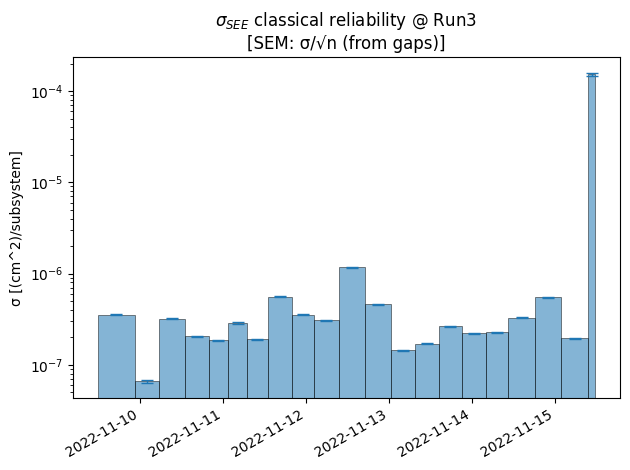

In [58]:

res_flu.to_csv(f"{out_prefix}_fluence.csv", index=False)

# --- Plots con etiquetas correctas ---
title_bar_rates=r"$\sigma_{SEE}$ classical reliability @ Run"+f"{run_id}"
ax = bar_rates(res_flu,title=title_bar_rates,
               y_var="sigma_SEE",
                logy=True, err_from_mu=True) # dont use garwood but poisson like)
# plt.yscale("log")             
plt.show()
plt.savefig(f"{out_prefix}_fluence_rates.png", dpi=150)
plt.close()

# print(res_flu["T"].describe())
# print(res_flu.nsmallest(5, "T")[["t_start","t_end","N","T","rate"]])

# # --- GLM (sobre bins ya saneados) ---
# print("Classic GLM")
# tr_flu = poisson_trend_test(res_flu, x_col="t_mid")
# print("GLM trend (FLU ): slope_per_hour=%.4g, p=%.3e, AIC=%.1f"
#       % (tr_flu["slope_per_hour"], tr_flu["p_value"], tr_flu["AIC"]))
# print("---")
# from radbin.glm import poisson_trend_test_plus, format_trend_report
# # --- GLM teniendo en cuenta sobredispersión y N grandes
# # Suponiendo que ya tienes 'res_flu' con columnas N, T, t_mid (datetime)
# out = poisson_trend_test_plus(
#     res_flu,
#     count="N", exposure="T", time_col="t_mid",
#     alpha=0.05,
#     se_method="robust",             # recomendado por defecto
#     use_lrt=True,
#     equivalence_rr=1.01,            # ±1% por hora = irrelevante
#     standardize_time=True           # reporta también slope por SD(t)
# )

# print(format_trend_report(out, time_unit="hora", alpha=0.05))
# # Si quieres ver un resumen corto del ajuste:
# print(out["summary_head"])



In [23]:
# Plots
plot_cumulative_fails(fails, title="Cumulative fails Run 3")
plt.savefig(f"{out_prefix}_cum.png", dpi=150)
plt.close()
plot_scaling_ratio(beam, label=r"Scaling ratio $\frac{dt_{eq}}{dt}$")
plt.savefig(f"{out_prefix}_scaleratio.png", dpi=150)
plt.close()

### Foreword de $\sigma$

En palabras de Melanie Berg


#### Sistemas Complejos
Considerando las distintas componentes:
Estamos viendo cuantos iones hasta que ocurra un evento de fallo $\rightarrow$ distribución exponencial.

$$

$$

$\sigma_{SEF}=1/\mu$ donde $\mu$ es el MFTF, en cada bin de tiempo para ver si ese valor evoluciona en el tiempo.
- incluye menos porciones de tiempo para analizar individualmente cada bin, como lo hace con los LET, observando si hay cambios

Además incluye en la presentación esta cross sección $\sigma_{SEF}$ que viene a ser el fallo de un solo evento en el espacio de fluencia. Donde no debe confundirse con $\sigma_{SEF} \neq P_{gen} \times P_{eff} \times P_{obs}$ as in, 
$$
P_{gen} \rightarrow H_{DUT}(s) \rightarrow P_{eff} \rightarrow \rightarrow P_{obs} \rightarrow \sigma_{SEF}
$$
- the generation its affected by the DUT system, $H_{DUT}(t)$ probability a ionization will cause an event
- the probability of ionization causing an effect and the topology of system will lead to an effect $P_{eff}$
- the probability that this test sytem its able to report the effect $T(s)$, considering as we can miss due to:
    - Missed events 
    - Latency considerations
    - False events
    - Flux and fluence control

In [24]:
res_flu.head()

,t_start,t_end,N,T,rate,lo,hi,t_mid,width_s,gap_N,gap_sum,gap_mean,gap_median,gap_p10,gap_p90,gap_p99,gap_min,gap_max
0,2022-11-09 11:50:54.109810944,2022-11-10 05:37:56.961296128,6954,3.322898e+10,6.539849e-09,6.387033e-09,6.695398e-09,2022-11-09 20:44:25.535553536,64022.851485,5840,2.861613e+10,4.900023e+06,7.313068e+05,216429.167275,2.138277e+06,4.601201e+06,61003.706400,1.504900e+10
1,2022-11-10 05:37:56.961296128,2022-11-10 19:57:22.415841536,8724,3.321203e+10,8.208623e-09,8.037265e-09,8.382713e-09,2022-11-10 12:47:39.688568832,51565.454545,7041,3.320772e+10,4.716335e+06,8.422140e+05,300301.929070,2.237004e+06,6.164891e+06,61.873787,7.329762e+09
2,2022-11-10 19:57:22.415841536,2022-11-11 07:01:05.242124288,7842,3.321778e+10,7.377451e-09,7.215061e-09,7.542574e-09,2022-11-11 01:29:13.828982912,39822.826282,6840,3.323588e+10,4.859046e+06,1.262233e+06,572580.542685,2.888383e+06,1.258479e+07,21.880524,3.813187e+09
3,2022-11-11 07:01:05.242124288,2022-11-11 19:58:49.425742592,12349,3.326491e+10,1.160100e-08,1.139728e-08,1.180745e-08,2022-11-11 13:29:57.333933440,46664.183618,10917,3.324772e+10,3.045500e+06,8.022701e+05,305112.008682,2.146774e+06,7.814913e+06,89.097977,3.653129e+09
4,2022-11-11 19:58:49.425742592,2022-11-12 09:28:53.695769600,10955,3.324381e+10,1.029797e-08,1.010602e-08,1.049264e-08,2022-11-12 02:43:51.560756096,48604.270027,9745,3.323044e+10,3.409999e+06,9.330577e+05,326250.161273,2.203380e+06,6.048460e+06,193.329498,2.757114e+09


### Sobre el modelo:
Sea en log-rate
$$
\hat\beta_1 = 0.0016 \quad (\text{log-rate por hora})
$$

Lo que importa no es el log, sino el **multiplicador de la tasa** por cada hora adicional:

$$
\text{Rate Ratio (RR)} = e^{\hat\beta_1} = e^{0.0016} \approx 1.0016
$$

Esto significa que, al avanzar una hora en el tiempo, la tasa esperada de fallos se multiplica por **1.0016**, es decir, aumenta un **0.16% por hora**.

Con el IC95%:

* Límite inferior: $e^{-0.004} \approx 0.996$ → posible **−0.4% por hora**
* Límite superior: $e^{0.007} \approx 1.007$ → posible **+0.7% por hora**


**El modelo general (General Linear Model)** es:

$$
\log \mathbb{E}[N_i] = \beta_0 + \beta_1 t_i + \log(T_i)
$$

* $N_i$: número de fallos en el bin $i$
* $T_i$: exposición (tiempo o fluencia en el bin)
* $t_i$: tiempo (horas desde el inicio)

**Hipótesis nula $H_0$:**

$$
\beta_1 = 0
$$

Esto equivale a que la tasa de fallos (ajustada por exposición) es **constante en el tiempo**.

**Hipótesis alternativa $H_1$:**

$$
\beta_1 \neq 0
$$

La tasa varía linealmente con el tiempo (en log-escala, o multiplicativamente en tasa).


#### Interpretación p-valor



En la salida

$$
p = 0.546
$$

Esto significa:

* Si en realidad la tasa de fallos **fuera constante** ($\beta_1=0$), la probabilidad de observar un efecto tan extremo o más que 0.0016 (en relación a su error estándar) sería de 54.6%.
* Como es muy grande, **no hay evidencia contra $H_0$**.
* En lenguaje práctico: el test no detecta ninguna tendencia clara; los datos son consistentes con una tasa estable.




## 0) Qué entregan los DataFrames de salida

Cada `res_*` devuelve columnas:

* `N`: eventos en el bin (incrementos del acumulado).
* `T`: tiempo de exposición del bin
  – en *wall* es tiempo real; en *fluence* o *eqN* es **tiempo escalado** $Δtₑq$.
* `rate = N/T`: estimador MLE de la tasa de Poisson.
* `lo, hi`: IC **Garwood** exacto para la tasa.
* `t_start, t_end, t_mid, width_s`.

---

## 1) Inspect scaling

```python
beq = compute_scaled_time_clipped(beam)
inspect_scaled_time(beq, label="beam")
```

### ¿Qué calcula?

* `compute_scaled_time_clipped` añade:

  * `dt_eq = dt · clip(φ_ref/φ_eff, 0, rmax)` con **floor** del flujo y **freeze** cuando `beam_on=0`.
  * `t_eq` (acumulado) y `scale_ratio = dt_eq/dt`.
* `inspect_scaled_time` resume la distribución de `scale_ratio` (mediana, p99, máx).

### ¿Qué esperar?

* **Mediana ≈ 1** si tu φ efectiva suele estar cerca de φ\_ref.
* **p99** moderado (p.ej. < 5–10) y **máx** ≪ `rmax` → sin *clipping* agresivo.
* Si **mediana < 1**: típicamente φ\_eff > φ\_ref (tiempo escalado “se comprime”).
* Si **mediana > 1**: φ\_eff < φ\_ref (tiempo escalado “se expande”).

### Red flags

* `p99` muy alto o `max` cercano a `rmax` → el floor o el cap están dominando y pueden distorsionar Δtₑq.

---

## 2) Vista **reset-locked** (tiempo real)

```python
res_wall = build_and_summarize(
  beam, fails, bin_mode="reset", T_source="wall",
  k_multiple=1, min_events_per_bin=min_events, area_norm=(area_run, area_ref)
)
```

### ¿Qué calcula?

* **Bordes de bins** pegados a **resets** (caídas/edges del acumulado y de `lfsrTMR`, clusterizados).
* `T` = **tiempo real** del bin, `N` = eventos en ese intervalo.
* `rate = N/T` con IC de Garwood.
* Si algún bin queda con `N < min_events`, se **fusiona** con el siguiente.

### ¿Qué esperar?

* Buena lectura “operativa” por ciclos de reset.
* Si el dispositivo está en **plateau**, las tasas deberían oscilar alrededor de un nivel \~constante (dentro de IC).
* Si hay **tendencia** (infant-mortality o desgaste), verás **pendiente** a través de bins.

### Checks rápidos

* La suma de `T` debe ser \~ la suma de `width_s` (consistencia de tiempo real).
* Ojo con bins muy largos con mucho tiempo **beam\_off**: pueden diluir la tasa.

---

## 3) Vista **equal-Δtₑq** (fluencia escalada)

```python
res_flu = build_and_summarize(
  beam, fails, bin_mode="fluence", n_bins=n_bins_flu,
  T_source="beam", min_events_per_bin=min_events, area_norm=(area_run, area_ref)
)
```

### ¿Qué calcula?

* Construye **n bins** con **igual tiempo escalado** `Δtₑq` (aprox), por lo que `T` es casi constante entre bins.
* `rate = N/T` refleja variación **intrínseca** del dispositivo (perfil del haz ya normalizado).

### ¿Qué esperar?

* En **plateau**: tasas casi **planas** (solo ruido de conteo, IC se solapan).
* En **bathtub** o **desgaste**: tasas con **U** (bathtub) o **pendiente** (desgaste).
* AIC/GLM suelen mejorar frente a la vista *wall* (modelo explica mejor).

### Checks

* Mira la columna `T`: debe ser **similar** entre bins (pequeña varianza).
* `rate` fuera de \[lo, hi] **no** debería ocurrir (si pasa, revisar inputs).

---

## 4) Vista **equal-count** (precisión constante)

```python
res_eqN = build_and_summarize(
  beam, fails, bin_mode="count", target_N=target_N,
  T_source="beam", min_events_per_bin=min_events, area_norm=(area_run, area_ref)
)
```

### ¿Qué calcula?

* Bins que contienen **≈ target\_N** eventos (después de merges), lo que hace que la **precisión relativa** sea \~constante:
  $\sigma_{\text{rel}}(\hat\lambda) \approx 1/\sqrt{N}$.

### ¿Qué esperar?

* **N** casi constante por bin; los **anchos de tiempo** se adaptan:
  – periodos de **alta tasa** → bins **cortos** en tiempo;
  – **baja tasa** → bins **largos**.
* Útil para comparar niveles de tasa con IC de magnitud similar a lo largo del eje.

### Checks

* `N` ≈ `target_N` (salvo el último bin o merges).
* `T` variable: es normal y deseable en esta vista.

---

## 5) Normalización por **área**

Aplica en las tres vistas vía `area_norm=(area_run, area_ref)`:

* Se escala `rate, lo, hi` por el factor $(A_{ref}/A_{run})$.
* Ej.: run3 con 16 subsistemas vs referencia 32 → factor **2×**.

---

## 6) Qué patrón valida cada vista

* **reset-locked (wall)**: “¿mi tasa cambia por ciclo/operación?” (incluye efectos de *duty cycle* del haz).
* **equal-Δtₑq**: “¿mi dispositivo muestra tendencia intrínseca una vez quitado el perfil de haz?” → ideal para decidir **plateau vs. desgaste**.
* **equal-count**: “quiero barras de error comparables” para una figura clara y chequeo visual de no-estacionariedad.

---

## 7) Señales de alerta generales

* Muchos bins con `N < min_events` (poca potencia) → subir `min_events` o rebinar.
* `scale_ratio` con cola extrema (max \~ rmax) → revisar `min_frac`, `rmax`, y `beam_on`.
* `rate` fuera de \[lo, hi] → error de contabilidad de eventos/tiempos.

Con esto deberías poder leer cada CSV/plot sabiendo exactamente **qué mide** y **qué forma esperas** si estás en plateau, en *infant mortality* o en desgaste.
